### Information System Seminar - Group 3 - Evaluation

This analysis is based on the experiment discussed in **Evaluation** section of our paper.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
# Note: dataframe 'tue' refers to that, participants used the website on Tuesday, surveyed on Wednesday. The same goes for wed, thu, fri, and sat (will be separated from 'final' in the following).

intro = pd.read_csv('1.Intro-Survey.csv')
tue = pd.read_csv('3.Wednesday-Survey.csv')
wed = pd.read_csv('4.Thursday-Survey.csv')
thu = pd.read_csv('5.Friday-Survey.csv')
fri = pd.read_csv('6.Saturday-Survey.csv')
final = pd.read_csv('7.Final-Survey.csv')

***
Basic cleaning: 
- Drop irrelevant columns
- Split `'final'` into `'sat'` and `'overall'`
- Shorten column names
- Replace punctuations

In [138]:
intro = intro.drop(columns=['IP', 'Submission ID', 'Submission Date'])
tue = tue.drop(columns=['IP', 'Submission ID', 'Submission Date'])
wed = wed.drop(columns=['IP', 'Submission ID', 'Submission Date'])
thu = thu.drop(columns=['IP', 'Submission ID', 'Submission Date'])
fri = fri.drop(columns=['Submission Date'])
final = final.drop(columns=['Submission Date'])

In [139]:
# split the final survey into: 'sat', 'overall'

sat = final.iloc[:, 0:8]

overall = final.iloc[:, 8:16]
# add 'email' to 'overall'
overall = pd.concat([final.iloc[:,0], overall], axis=1)

In [140]:
# Make column names shorter

intro= intro.rename(columns={intro.columns[0]: 'email', intro.columns[1]: 'age', intro.columns[2]: 'gender', intro.columns[3]: 'education', intro.columns[4]: 'living_situation', 
                             intro.columns[5]: 'household_size', intro.columns[6]: 'rate_electricity_knowledge', intro.columns[7]: 'opinion_to_statement',
                             intro.columns[8]: 'rate_CO2_importance', intro.columns[9]: 'rate_frequency_lower_CO2_actions'})

intro['household_size'] = intro['household_size'].replace({'Two people': '2 people', 'I live alone': '1 person'})

tue = tue.rename(columns={tue.columns[0]: 'email', tue.columns[1]: 'logged', tue.columns[2]: 'followed', tue.columns[3]: 'followed_how', tue.columns[4]: 'devices_used_good_hours',
                          tue.columns[5]: 'devices_not_used_bad_hours', tue.columns[6]: 'reason_not_followed', tue.columns[7]: 'reason_not_logged'})

wed = wed.rename(columns={wed.columns[0]: 'email', wed.columns[1]: 'logged', wed.columns[2]: 'followed', wed.columns[3]: 'followed_how', wed.columns[4]: 'devices_used_good_hours', 
                          wed.columns[5]: 'devices_not_used_bad_hours', wed.columns[6]: 'reason_not_followed', wed.columns[7]: 'reason_not_logged'})

thu = thu.rename(columns={thu.columns[0]: 'email', thu.columns[1]: 'logged', thu.columns[2]: 'followed', thu.columns[3]: 'followed_how', thu.columns[4]: 'devices_used_good_hours', 
                          thu.columns[5]: 'devices_not_used_bad_hours', thu.columns[6]: 'reason_not_followed', thu.columns[7]: 'reason_not_logged'})

fri = fri.rename(columns={fri.columns[0]: 'email', fri.columns[1]: 'logged', fri.columns[2]: 'followed', fri.columns[3]: 'followed_how', fri.columns[4]: 'devices_used_good_hours', 
                          fri.columns[5]: 'devices_not_used_bad_hours', fri.columns[6]: 'reason_not_followed', fri.columns[7]: 'reason_not_logged'})

sat = sat.rename(columns={sat.columns[0]: 'email', sat.columns[1]: 'logged', sat.columns[2]: 'followed', sat.columns[3]: 'followed_how', sat.columns[4]: 'devices_used_good_hours', 
                          sat.columns[5]: 'devices_not_used_bad_hours', sat.columns[6]: 'reason_not_followed', sat.columns[7]: 'reason_not_logged'})

overall = overall.rename(columns={overall.columns[0]: 'email'}) # overall's other col names remain the same

In [141]:
# replace all '; ' and '\n' with a single semicolon ';'

def replace_into_semicolon(df):
    for col in df.columns:
        df[col] = df[col].replace({'; ': ';', '\n': ';'}, regex=True)
    return df

survey_list = [intro, tue, wed, thu, fri, sat, overall]

for survey in survey_list:
    survey = replace_into_semicolon(survey)

***
Create wide format data: 
- Each participant is identified via email and represented as one row
- All surveys are merged column by column, with suffixes being added

In [142]:
# survey_list = [intro, tue, wed, thu, fri, sat, overall]
survey_suf = ["_intro", "_tue", "_wed", "_thu", "_fri", "_sat", "_overall"]

# function to add suffix to columns of a df, excluding a specific column ('email')
def add_suffix_to_columns(df, suffix, exclude_column):
    df.columns = [f"{col}{suffix}" if col != exclude_column else col for col in df.columns]
    return df

# add suffix to columns of each survey
for i, (survey, name_suffix) in enumerate(zip(survey_list, survey_suf)):
    survey_list[i] = add_suffix_to_columns(survey.copy(), name_suffix, 'email')


# merge all dataframes on 'email' using an outer join to include all rows/participants from all surveys
wide_format = survey_list[0]  
for i in survey_list[1:]:  # skip the intro survey since it's already the base
    wide_format = pd.merge(wide_format, i, on='email', how='outer')

***
Create long format data:
- Only possible with repeated daily surveys, as they have the same survey questions
- `'email` and `'used_day'` combined together as the identifier

In [143]:
tue_long = tue.copy()
wed_long = wed.copy()
thu_long = thu.copy()
fri_long = fri.copy()
sat_long = sat.copy()

# add a new column to each df to indicate the day participants used the website
# used integers, as this column will be used for sorting
tue_long['used_day'] = 2
wed_long['used_day'] = 3
thu_long['used_day'] = 4
fri_long['used_day'] = 5
sat_long['used_day'] = 6

# concatenate into a long format DataFrame
long_format = pd.concat([tue_long, wed_long, thu_long, fri_long, sat_long], ignore_index=True)

long_format = long_format.sort_values(by=['email', 'used_day'])

long_format = long_format.reset_index(drop=True)

# reorder the columns
col_order = ['email', 'used_day'] + [col for col in long_format.columns if col not in ['email', 'used_day']]
long_format = long_format[col_order]

***
Define the subset of participants of our interest as those who have finished:
- the intro survey
- at least one of the daily surveys
- the overall survey (the final survey)

The following analysis will only focus on this subset.

In [144]:
# emails of participants who filled in at least 1 daily survey
emails_of_interest = long_format.email.unique() 

# participants who filled in at least 1 daily survey, from wide_format (so it is on individual level)
atleast_one_daily = wide_format[wide_format['email'].isin(emails_of_interest)] 

# participants who filled in at least 1 daily survey, and filled in intro + overall (filtered by 2 compulsory questions in the intro and overall survey respectively)
satisfied_participants = atleast_one_daily[atleast_one_daily['age_intro'].notna()&
                                           atleast_one_daily['How likely are you to use Cleaner-Tomorrow in the future?_overall'].notna()]

# store emails of satisfied participants
satisfied_participants_email = satisfied_participants['email']

In [145]:
satisfied_participants

,email,age_intro,gender_intro,education_intro,living_situation_intro,household_size_intro,rate_electricity_knowledge_intro,opinion_to_statement_intro,rate_CO2_importance_intro,rate_frequency_lower_CO2_actions_intro,logged_tue,followed_tue,followed_how_tue,devices_used_good_hours_tue,devices_not_used_bad_hours_tue,reason_not_followed_tue,reason_not_logged_tue,logged_wed,followed_wed,followed_how_wed,devices_used_good_hours_wed,devices_not_used_bad_hours_wed,reason_not_followed_wed,reason_not_logged_wed,logged_thu,followed_thu,followed_how_thu,devices_used_good_hours_thu,devices_not_used_bad_hours_thu,reason_not_followed_thu,reason_not_logged_thu,logged_fri,followed_fri,followed_how_fri,devices_used_good_hours_fri,devices_not_used_bad_hours_fri,reason_not_followed_fri,reason_not_logged_fri,logged_sat,followed_sat,followed_how_sat,devices_used_good_hours_sat,devices_not_used_bad_hours_sat,reason_not_followed_sat,reason_not_logged_sat,"Did you encounter any problems, when using Cleaner-Tomorrow?_overall",What information or details were missing?_overall,What stopped you from following the recommendation more often?_overall,How likely are you to use Cleaner-Tomorrow in the future?_overall,How likely are you to recommend using Cleaner-Tomorrow to others?_overall,Hypothetically: How (what channel) would you prefer to be informed about an electricity usage recommendation?_overall,"Do you have any suggestions for improvements of Cleaner-Tomorrow, or feedback about the surveys?_overall"
0,lena.stoedter@gmx.de,18-24,Female,High School,renter,2 people,3.0,True,4.0,4.0,YES,NO,NaN,NaN,NaN,My usage just wasn't flexible - devices needed to be used there and then.,NaN,YES,YES,"I intentionally reduced electricity use in the not recommended ""bad hours"".",NaN,Small devices charger;Taking a shower (only if electric water heater is used!);Television,NaN,NaN,YES,YES,"I intentionally used electricity in the recommended ""good hours"", instead of other hours.",Washing Machine;Dishwasher,NaN,NaN,NaN,YES,NO,NaN,NaN,NaN,My usage just wasn't flexible - devices needed to be used there and then.,NaN,YES,YES,"I intentionally used electricity in the recommended ""good hours"", instead of other hours.",Dishwasher;Small devices charger;Taking a shower (only if electric water heater is used!),NaN,NaN,NaN,Not at all,NaN,Working Hours,4.0,4.0,"Messaging App (WhatsApp, signal, etc...);A dedicated App",NaN
1,alona.zharova@hu-berlin.de,35-44,Female,Doctoral Degree/advanced degree,home owner,3-4 people,4.0,True,5.0,4.0,YES,NO,NaN,NaN,NaN,My usage just wasn't flexible - devices needed to be used there and then.,NaN,YES,YES,"I intentionally used electricity in the recommended ""good hours"", instead of other hours.",Washing Machine,NaN,NaN,NaN,YES,YES,"I intentionally used electricity in the recommended ""good hours"", instead of other hours.",Laptop charger,NaN,NaN,NaN,YES,NO,NaN,NaN,NaN,I forgot about the recommendation.,NaN,YES,NO,NaN,NaN,NaN,The given time-frames were too inconvenient for my personal needs.,NaN,NaN,NaN,NaN,5.0,5.0,A dedicated App,NaN
4,angelene.ullner@gmail.com,35-44,Female,Bachelor’s Degree,renter,3-4 people,2.0,True,5.0,2.0,YES,YES,Both.,Washing Machine;Dryer,Washing Machine;Dryer;Laptop charger;Small devices charger;Taking a shower (only if electric water heater is used!),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YES,YES,Both.,Washing Machine;Dishwasher,Taking a shower (only if electric water heater is used!),NaN,NaN,YES,YES,Both.,Washing Machine;Dryer;Dishwasher,Laptop charger;Small devices charger,NaN,NaN,YES,NO,NaN,NaN,NaN,The given time-frames were too inconvenient for my personal needs.,NaN,The main cleaner tomorrow page wasn’t so clear that I had to click on the map. I didn’t even know which state Berlin was so the names of the state would have been helpful for me. It also didn’t really load properly and then I didn’t see that the info was lower down on the page so I didn’t realise I had to scroll down for the info.,Map labels.;;Impact of my ac

***
Demographics:
- What is your age?
- What is your gender?
- What is the highest level of education you have completed?
- What describes your living situation best?
- How many people live in your household in total (including yourself)?


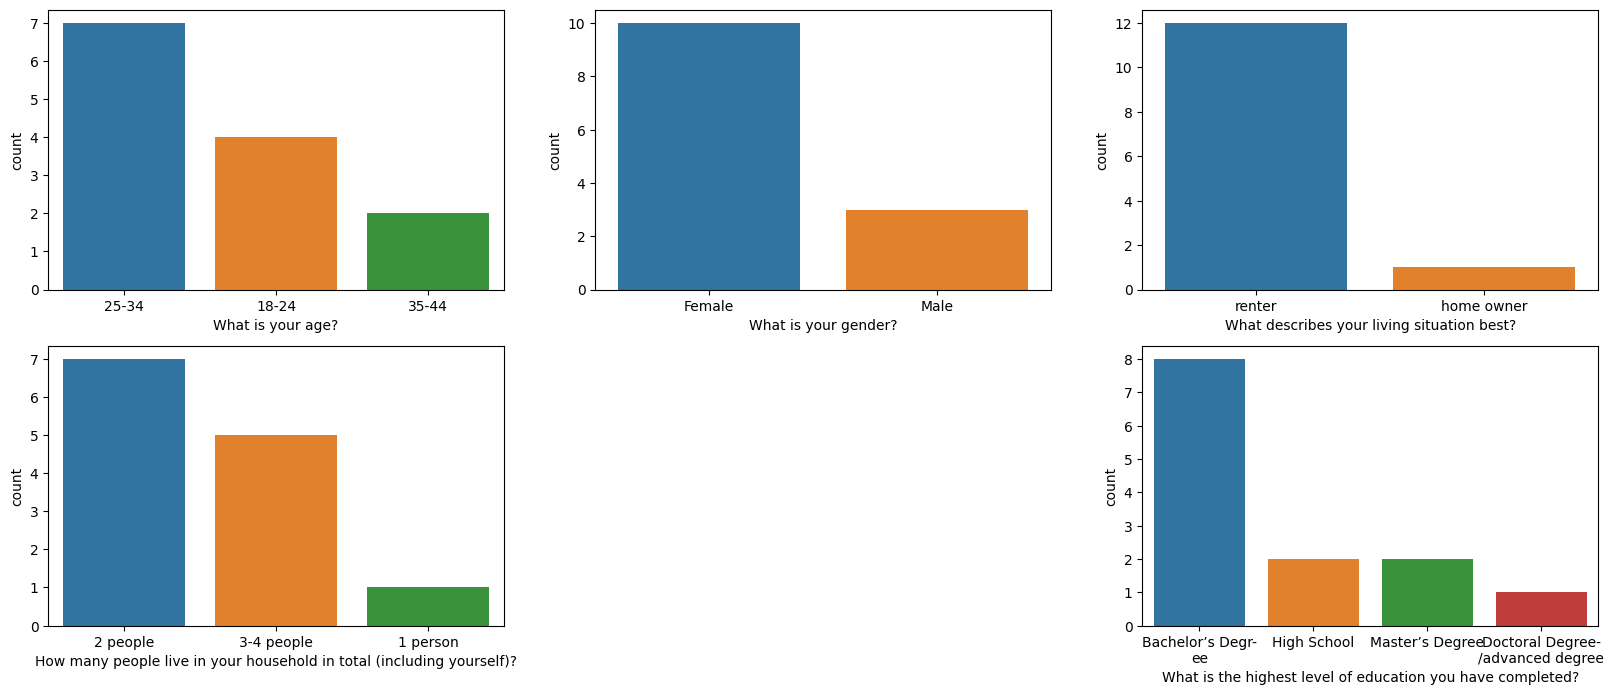

In [146]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8))

age = sns.countplot(x='age_intro', data=satisfied_participants, order=satisfied_participants.age_intro.value_counts().index, ax=axes[0,0])
axes[0,0].set_xlabel('What is your age?')

gender = sns.countplot(x='gender_intro', data=satisfied_participants, order=satisfied_participants.gender_intro.value_counts().index, ax=axes[0,1])
axes[0,1].set_xlabel('What is your gender?')

living_situation = sns.countplot(x='living_situation_intro', data=satisfied_participants, order=satisfied_participants.living_situation_intro.value_counts().index, ax=axes[0,2])
axes[0,2].set_xlabel('What describes your living situation best?')

household_size = sns.countplot(x='household_size_intro', data=satisfied_participants, order=satisfied_participants.household_size_intro.value_counts().index, ax=axes[1,0])
axes[1,0].set_xlabel('How many people live in your household in total (including yourself)?')

education = sns.countplot(x='education_intro', data=satisfied_participants, order=satisfied_participants.education_intro.value_counts().index, ax=axes[1,2])
axes[1,2].set_xlabel('What is the highest level of education you have completed?')
tick_labels = [text[:15] + '-' + '\n' + text[15:] if len(text) > 15 else text for text in satisfied_participants['education_intro'].value_counts().index] 
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels) 

axes[1][1].set_visible(False)

- Initial knowledge level of electricity and emissions
- Engagement in emission reduction

Text(0.5, 0, 'Have you taken concrete actions / made decisions specifically to \n lower the CO2 emissions impact of your lifestyle?')

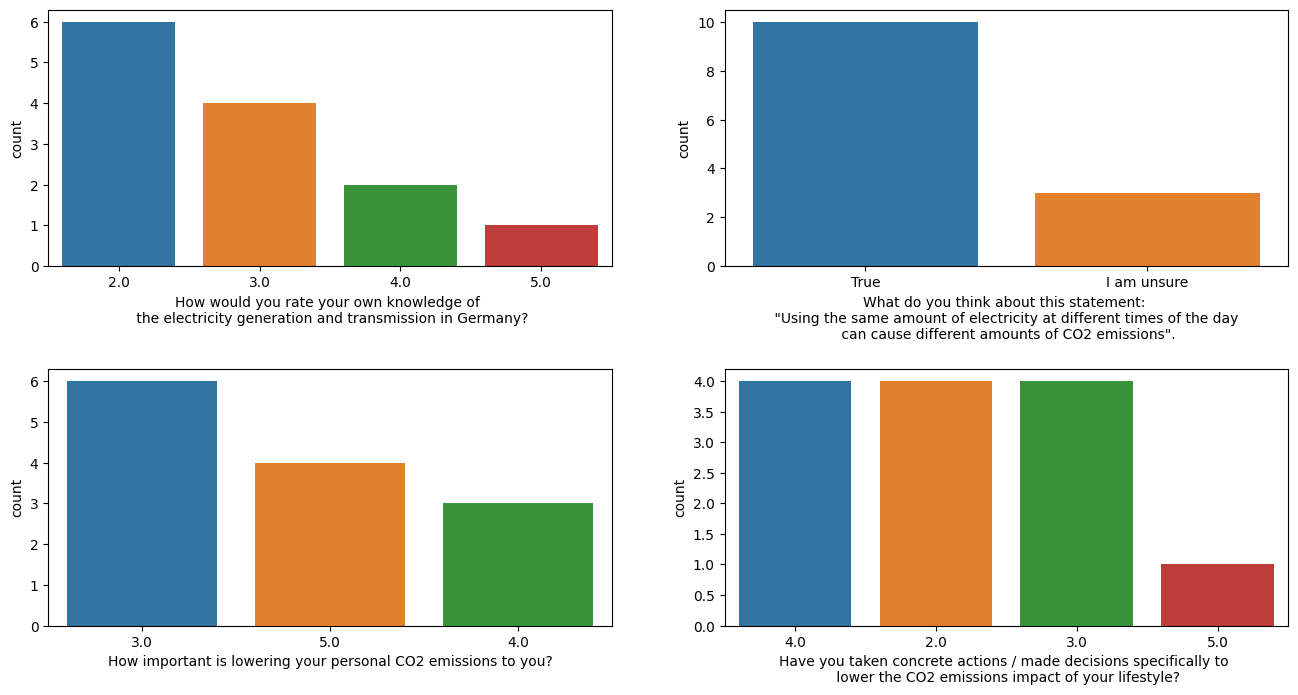

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

plt.subplots_adjust(hspace=0.4)

rate_electricity_knowledge = sns.countplot(x='rate_electricity_knowledge_intro', data=satisfied_participants, order=satisfied_participants.rate_electricity_knowledge_intro.value_counts().index, ax=axes[0,0])
axes[0,0].set_xlabel('How would you rate your own knowledge of \n the electricity generation and transmission in Germany?')

opinion_to_statement = sns.countplot(x='opinion_to_statement_intro', data=satisfied_participants, order=satisfied_participants.opinion_to_statement_intro.value_counts().index, ax=axes[0,1])
axes[0,1].set_xlabel('What do you think about this statement: \n "Using the same amount of electricity at different times of the day \n can cause different amounts of CO2 emissions".')

rate_CO2_importance = sns.countplot(x='rate_CO2_importance_intro', data=satisfied_participants, order=satisfied_participants.rate_CO2_importance_intro.value_counts().index, ax=axes[1,0])
axes[1,0].set_xlabel('How important is lowering your personal CO2 emissions to you?')

rate_frequency_lower_CO2_actions = sns.countplot(x='rate_frequency_lower_CO2_actions_intro', data=satisfied_participants, order=satisfied_participants.rate_frequency_lower_CO2_actions_intro.value_counts().index, ax=axes[1,1])
axes[1,1].set_xlabel('Have you taken concrete actions / made decisions specifically to \n lower the CO2 emissions impact of your lifestyle?')

Number of participants that logged into the website every day:

In [148]:
pd.set_option('display.max_columns', None)

logged_cols = ['logged_tue', 'logged_wed', 'logged_thu', 'logged_fri', 'logged_sat']

logged_everyday = satisfied_participants[(satisfied_participants[logged_cols] == 'YES').all(axis=1)]

print("There are {} participants who logged in every day.".format(logged_everyday.shape[0]))

There are 6 participants who logged in every day.


Reasons for not logging in:

In [149]:
reasons_not_logged_cols = ['reason_not_logged_tue', 'reason_not_logged_wed', 'reason_not_logged_thu', 'reason_not_logged_fri', 'reason_not_logged_sat']

# satisfied_participants.loc[:, logged_cols + reasons_not_logged_cols]

long_format[long_format['email'].isin(satisfied_participants_email)].reason_not_logged.value_counts()

I missed your email or did not have any time to log in.    3
Name: reason_not_logged, dtype: int64

Number of participants who followed the recommendations every day:

In [150]:
followed_cols = ['followed_tue', 'followed_wed', 'followed_thu', 'followed_fri', 'followed_sat']

followed_everyday = satisfied_participants[(satisfied_participants[followed_cols] == 'YES').all(axis=1)] 

print("There are {} participants who followed the recommendations every day.".format(followed_everyday.shape[0]))

There are 2 participants who followed the recommendations every day.


Reasons for not following the recommendations:

In [151]:
long_format[long_format['email'].isin(satisfied_participants_email)].reason_not_followed.value_counts()

# # The least common reasons should be 'others', specified by participants. Thus, we can merge themm into one category:
# # long_format['reason_not_followed'] = long_format['reason_not_followed'].replace({'I wasnt home during the time frames': 'Others', 'Wasnt home': 'Others'})

My usage just wasn't flexible - devices needed to be used there and then.    9
I forgot about the recommendation.                                           4
The given time-frames were too inconvenient for my personal needs.           4
I wasnt home during the time frames                                          1
Wasnt home                                                                   1
Name: reason_not_followed, dtype: int64

How did participants follow the recommendations across the 5 days?

Predominantly, shifting consumption into "good hours"

In [152]:
print(long_format[long_format['email'].isin(satisfied_participants_email)].followed_how.value_counts())

I intentionally used electricity in the recommended "good hours", instead of other hours.    22
I intentionally reduced electricity use in the not recommended "bad hours".                  11
Both.                                                                                         6
Name: followed_how, dtype: int64


Count shifted devices across the 5 days:

Text(0.5, 1.0, 'Shifted devices across 5 days')

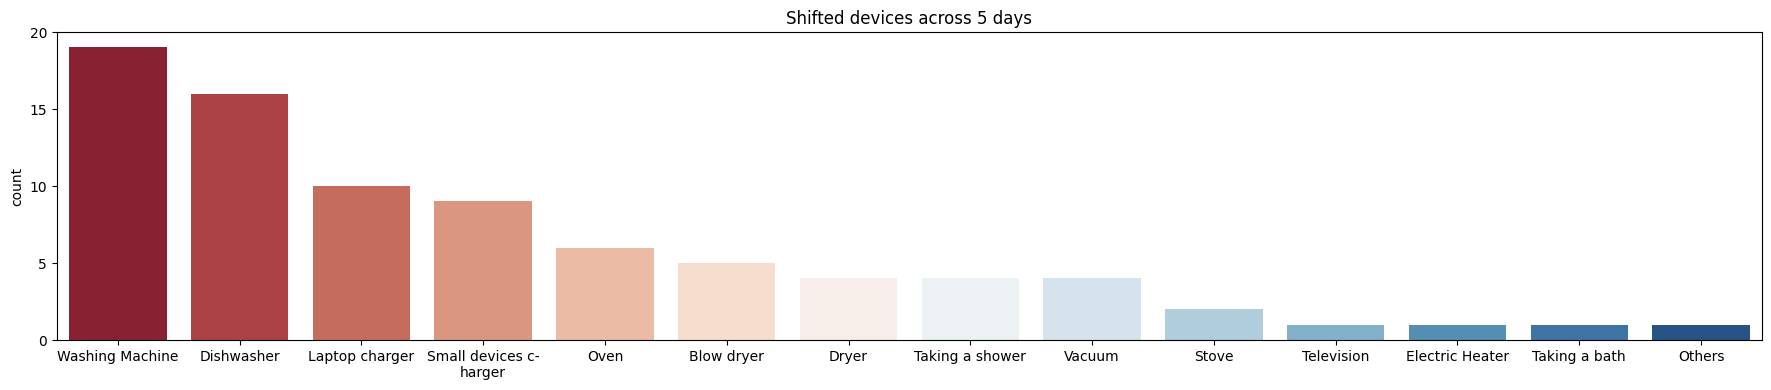

In [153]:
# the two columns of shifted devices (either into good hours, or avoid in bad hours)
devices_df = long_format[long_format['email'].isin(satisfied_participants_email)].iloc[:, 5:7]

# get the count of each shifted device
all_devices_str = ';'.join(devices_df.stack().dropna())

all_devices_list = all_devices_str.split(';')

device_counts_df = pd.DataFrame(all_devices_list, columns=['devices'])
device_counts = device_counts_df['devices'].value_counts().reset_index()
device_counts.columns = ['devices', 'count']

# delete the content in the brackets
device_counts['devices'] = device_counts['devices'].replace({'\s*\([^)]*\)': ''}, regex=True)
# replace into 'Others'
device_counts['devices'] = device_counts['devices'].replace({'Other: List multiple if needed': 'Others'})

palette = sns.color_palette("RdBu", n_colors=14)
plt.figure(figsize=(22, 4))
device_plot = sns.barplot(x='devices', y='count', data=device_counts, palette=palette)
tick_labels = [text[:15] + '-' + '\n' + text[15:] if len(text) > 15 else text for text in device_counts['devices'].value_counts().index] # Splitting labels into multiple lines
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels) 
plt.xlabel(None)
plt.yticks(np.arange(0, 21, 5)) 
plt.title('Shifted devices across 5 days')

Compute how much electricity was shifted in total:  

- Based on online resources for standard electricity consumption of home appliances:  
    https://unboundsolar.com/solar-information/power-table  
    https://www.energysage.com/electricity/house-watts/how-many-watts-does-an-electric-oven-and-stove-use/  
    https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-space-heater-use/  
- Chose estimated usage durations for each device
- For `'Others'`, used the median consumption and usage duration

In [154]:
device_counts['watts'] = [800, 1350, 100, 7, 1200, 1500, 3000, 18000, 1000, 2000, 175, 1500, 18000, 1350]
device_counts['hours'] = [1, 2, 1, 1, 0.5, 0.15, 2, 0.25, 0.4, 0.5, 1, 3, 0.25, 1]
device_counts['shifted_electricity'] = device_counts['watts'] * device_counts['hours'] * device_counts['count']

summary_row = {'devices': 'Total (Wh)', 'count': '', 'watts': '', 'hours': '', 'shifted_electricity': device_counts['shifted_electricity'].sum()}
device_counts = device_counts.append(summary_row, ignore_index=True)

device_counts

C:\Users\Qinwei He\AppData\Local\Temp\ipykernel_11892\2391263993.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  device_counts = device_counts.append(summary_row, ignore_index=True)


,devices,count,watts,hours,shifted_electricity
0,Washing Machine,19,800,1.0,15200.0
1,Dishwasher,16,1350,2.0,43200.0
2,Laptop charger,10,100,1.0,1000.0
3,Small devices charger,9,7,1.0,63.0
4,Oven,6,1200,0.5,3600.0
5,Blow dryer,5,1500,0.15,1125.0
6,Dryer,4,3000,2.0,24000.0
7,Taking a shower,4,18000,0.25,18000.0
8,Vacuum,4,1000,0.4,1600.0
9,Stove,2,2000,0.5,2000.0


Two questions in the final survey, for investigating participants willingness to continue use Cleaner Tomorrow or recommend it to others:

Text(0.5, 0, 'How likely are you to recommend using Cleaner-Tomorrow to others?')

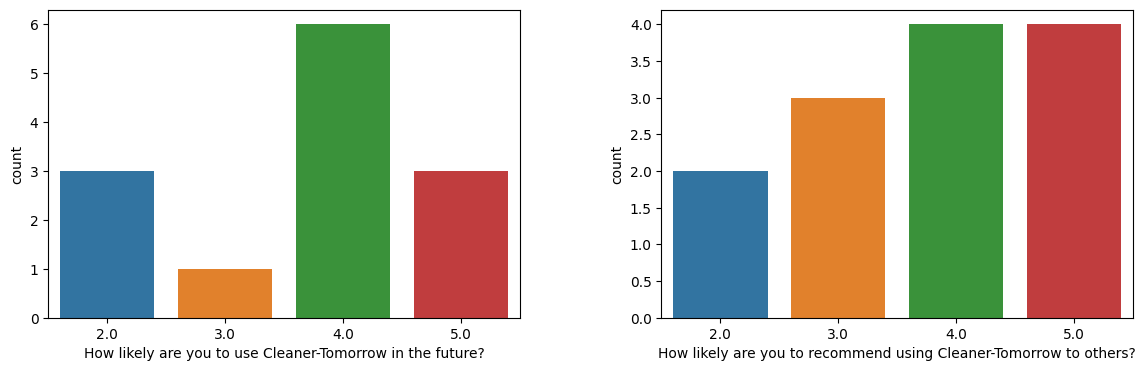

In [155]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plt.subplots_adjust(wspace=0.3)

sns.countplot(x='How likely are you to use Cleaner-Tomorrow in the future?_overall', data=satisfied_participants, ax=axes[0])
axes[0].set_xlabel('How likely are you to use Cleaner-Tomorrow in the future?')

sns.countplot(x='How likely are you to recommend using Cleaner-Tomorrow to others?_overall', data=satisfied_participants, ax=axes[1])
axes[1].set_xlabel('How likely are you to recommend using Cleaner-Tomorrow to others?')

Suggestions for improvements:

In [156]:
pd.set_option('display.max_colwidth', None)

suggestions = satisfied_participants.iloc[:, [45, 46, 47, 51]].copy()

for col in suggestions.columns:
    suggestions[col] = suggestions[col].replace({';;': ';', '.;': ';'}, regex=True)

suggestions

,"Did you encounter any problems, when using Cleaner-Tomorrow?_overall",What information or details were missing?_overall,What stopped you from following the recommendation more often?_overall,"Do you have any suggestions for improvements of Cleaner-Tomorrow, or feedback about the surveys?_overall"
0,Not at all,NaN,Working Hours,NaN
1,NaN,NaN,NaN,NaN
4,The main cleaner tomorrow page wasn’t so clear that I had to click on the map. I didn’t even know which state Berlin was so the names of the state would have been helpful for me. It also didn’t really load properly and then I didn’t see that the info was lower down on the page so I didn’t realise I had to scroll down for the info.,Map labels;Impact of my action.,"My personal schedule didn’t match up to the recommendation;Sometimes a recommendation was for the night (2am) where I didn’t even have the recommendation yet;Lastly, I don’t check my emails very often.","I love the concept! Execution needs to be better and be implemented into one’s lifestyle through an app that adds value like how much one really saves and maybe partner with an organisation to offer incentives. Something like, but not, like what health insurers offer when you get teeth cleaning or get fit then you get a cash back. In that vein, something like when you save x amount of energy by switching to renewables then you get 20€ cash back or whatever else is attractive."
5,Not at all. It was easy to understand and helpfunctie to get Daily notifications.,I was a Little confused about the Control areas.,Sometimes I was just very busy and could Not always Focus on the recommended Hours.,NaN
6,No,How much to use,Work,NaN
8,Website not usable on mobile devices,Full rating of each hour in the day would be nice,Hard to use on mobile device,"Show full graph of rating of each hour so ""good"" hours can fit together better with daily schedul;Improve UI on mobile devices ;"
9,No,-,I forgot about the recommendations,-
10,No,-,The good hours didn’t fit into my schedule,-
11,E-Mails ended up in my spam folder,NaN,"I didn’t know about the specific impact of my actions, sometimes I am just not that flexible in my use and it takes some reorganization",NaN
14,NaN,NaN,NaN,NaN


Hypothetically: How (what channel) would participants prefer to be informed about an electricity usage recommendation?

In [157]:
channels = satisfied_participants.iloc[:, 50].copy()

channels = pd.Series(channels.str.split(';', expand=True).stack().reset_index(drop=True), name='Channels')

channels_counts = channels.value_counts().reset_index()
channels_counts.columns = ['Channels', 'Count']
 
channels_counts

,Channels,Count
0,A dedicated App,7
1,"Messaging App (WhatsApp, signal, etc...)",4
2,SMS,2
3,Email notifications,2
4,Log-in on website,1
